<div style="background-color:#FCE205; padding:10px; border-radius:5px; color:black; font-weight:bold;">
    <h2>Predicting Bee Colonie Loss for US states</h2>
</div>

In [1]:
# importing libraries
import numpy as np 
import pandas as pd 
import os
import sys
from datetime import datetime, date

import seaborn as sns 
import matplotlib.pyplot as plt 
from matplotlib.ticker import ScalarFormatter

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
from pmdarima import auto_arima

import warnings # Supress warnings 
warnings.filterwarnings('ignore')

from colorama import Fore

import xgboost as xgb

sys.path.append(os.path.abspath('../utils'))
from tinne_utils import create_quarterly_index, subset_by_state, adf_test, plot_colony_timeseries

In [2]:
# set working directory
ITM_DIR = os.path.join(os.getcwd(), '../data/cleaned')

In [3]:
# read in data
bees = pd.read_csv(os.path.join(ITM_DIR, 'bees_clean_imputed.csv'))

In [4]:
bees.columns

Index(['state', 'latitude', 'longitude', 'quarter', 'temperature_2m_meanmean',
       'temperature_2m_meansum', 'relative_humidity_2m_meanmean',
       'relative_humidity_2m_meansum', 'wind_speed_10m_maxmax',
       'temperature_2m_maxmax', 'relative_humidity_2m_maxmax',
       'temperature_2m_minmin', 'relative_humidity_2m_minmin',
       'precipitation_hours_sum', 'moderate_drizzle_sum', 'moderate_rain_sum',
       'light_rain_sum', 'heavy_rain_sum', 'overcast_sum', 'partly_cloudy_sum',
       'clear_sky_sum', 'light_drizzle_sum', 'mainly_clear_sum',
       'heavy_drizzle_sum', 'light_snow_sum', 'heavy_snow_sum',
       'moderate_snow_sum', 'year', 'D0_mean', 'D1_mean', 'D2_mean', 'D3_mean',
       'D4_mean', 'D0_max', 'D1_max', 'D2_max', 'D3_max', 'D4_max',
       'state_code', 'num_colonies', 'max_colonies', 'lost_colonies',
       'percent_lost', 'added_colonies', 'renovated_colonies',
       'percent_renovated', 'varroa_mites', 'other_pests_and_parasites',
       'diseases', 'pes

In [5]:
# drop unneeded rows
bees = bees.drop('state_code', axis = 1)

In [6]:
bees.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1436 entries, 0 to 1435
Data columns (total 50 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   state                          1436 non-null   object 
 1   latitude                       1436 non-null   float64
 2   longitude                      1436 non-null   float64
 3   quarter                        1436 non-null   int64  
 4   temperature_2m_meanmean        1436 non-null   float64
 5   temperature_2m_meansum         1436 non-null   float64
 6   relative_humidity_2m_meanmean  1436 non-null   float64
 7   relative_humidity_2m_meansum   1436 non-null   float64
 8   wind_speed_10m_maxmax          1436 non-null   float64
 9   temperature_2m_maxmax          1436 non-null   float64
 10  relative_humidity_2m_maxmax    1436 non-null   float64
 11  temperature_2m_minmin          1436 non-null   float64
 12  relative_humidity_2m_minmin    1436 non-null   f

<div style="background-color:#FCE205; padding:10px; border-radius:5px; color:black; font-weight:bold;">
    <h3>Set State for Model Selection</h3>
</div>

In [7]:
state = 'Ohio'
state_bees = subset_by_state(bees,state)
state_bees = create_quarterly_index(state_bees)

<div style="background-color:#FCE205; padding:10px; border-radius:5px; color:black; font-weight:bold;">
    <h3>Time Series Sanity Check</h3>
</div>

### Chronological Order and Equidistant Timestamps

The data should be in chronological order and the timestamps should be equidistant in time series. The chronological order can be achieved by sorting the dataframe by the timestamps. Equidisant timestamps indicates constant time intervals. To check this, the difference between each timestamp can be taken. If this is not the case, you can decide on a constant time interval and resample the data.

In [11]:
state_bees = state_bees.sort_values(by='date')

# Check time intervals
state_bees['delta'] = state_bees['date'] - state_bees['date'].shift(1)

state_bees[['date', 'delta']]

,date,delta
33,2015-01-01,NaT
49,2015-04-01,90 days
112,2015-07-01,91 days
168,2015-10-01,92 days
224,2016-01-01,92 days
244,2016-04-01,91 days
290,2016-07-01,91 days
339,2016-10-01,92 days
373,2017-01-01,92 days
428,2017-04-01,90 days


The results confirm the time interval is one quarter (90-92 days) and the data is in chronological order.

<div style="background-color:#FCE205; padding:10px; border-radius:5px; color:black; font-weight:bold;">
    <h2>Time Series Evaluation for Model Selection</h2>
</div>

Some time-series models, assume that the underlying data is stationary. 

Stationarity describes that the time-series has:

- constant mean and mean is not time-dependent
- constant variance and variance is not time-dependent
- constant covariance and covariance is not time-dependent

Stationarity is checked visually and statistically by the Augmented Dickey Fuller test

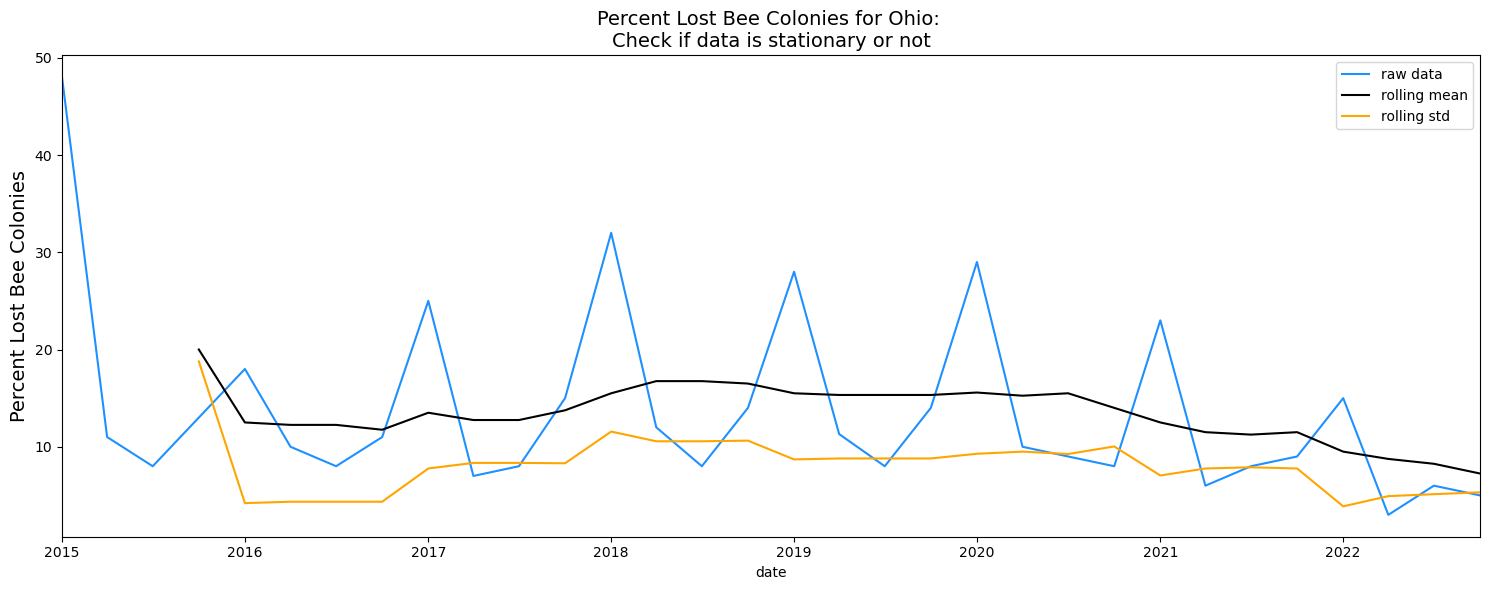

In [8]:
# A year has 4 quarters (4 quarters * 90-91 days per quarter) approximately.
rolling_window = 4

fig, ax = plt.subplots(figsize=(15, 6))

sns.lineplot(x=state_bees['date'], y=state_bees['percent_lost'], ax=ax, color='dodgerblue', label='raw data')
sns.lineplot(x=state_bees['date'], y=state_bees['percent_lost'].rolling(rolling_window).mean(), ax=ax, color='black', label='rolling mean')
sns.lineplot(x=state_bees['date'], y=state_bees['percent_lost'].rolling(rolling_window).std(), ax=ax, color='orange', label='rolling std')

ax.set_title(f'Percent Lost Bee Colonies for {state}: \nCheck if data is stationary or not', fontsize=14)
ax.set_ylabel('Percent Lost Bee Colonies', fontsize=14)
ax.set_xlim([date(2015, 1, 1), date(2022, 10, 1)])

# Disable scientific notation on y-axis
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
ax.ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.show()

In [18]:
adf_test(state_bees['percent_lost'], state)

Augmented Dickey-Fuller Test: Ohio
ADF test statistic       0.339090
p-value                  0.979069
# lags used              4.000000
# observations          27.000000
critical value (1%)     -3.699608
critical value (5%)     -2.976430
critical value (10%)    -2.627601
Data is non-stationary


<div style="background-color:#FCE205; padding:10px; border-radius:5px; color:black; font-weight:bold;">
    <h3>Time Series Decomposition</h3>
</div>

# aic punishes more complex models due to their potential to overfit the data

### Determine the (p,q) ARMA Orders using <tt>pmdarima.auto_arima</tt>
This tool should give just $p$ and $q$ value recommendations for our dataset.

In [ ]:
# set date to index
state_bees.set_index('date', inplace=True) 

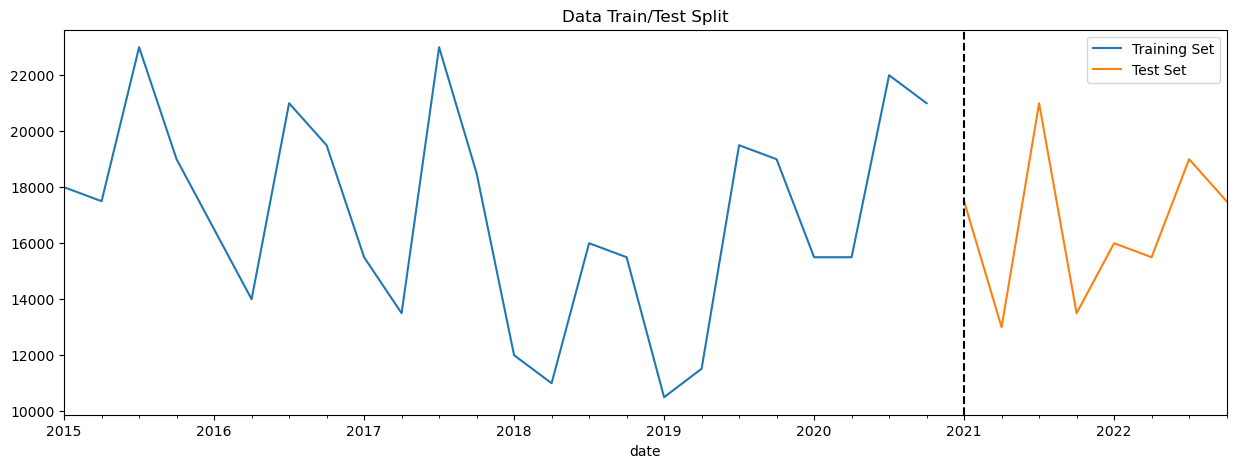

In [ ]:
split_date = '2021-01-01'
train = state_bees.loc[state_bees.index < split_date]
test = state_bees.loc[state_bees.index >= split_date]

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, y= 'num_colonies', label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, y= 'num_colonies', label='Test Set')
ax.axvline(split_date, color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [ ]:
FEATURES = [
       'latitude', 'longitude', 'temperature_2m_meanmean',
       'temperature_2m_meansum', 'relative_humidity_2m_meanmean',
       'relative_humidity_2m_meansum', 'wind_speed_10m_maxmax',
       'temperature_2m_maxmax', 'relative_humidity_2m_maxmax',
       'temperature_2m_minmin', 'relative_humidity_2m_minmin',
       'precipitation_hours_sum', 'moderate_drizzle_sum', 'moderate_rain_sum',
       'light_rain_sum', 'heavy_rain_sum', 'overcast_sum', 'partly_cloudy_sum',
       'clear_sky_sum', 'light_drizzle_sum', 'mainly_clear_sum',
       'heavy_drizzle_sum', 'light_snow_sum', 'heavy_snow_sum',
       'moderate_snow_sum', 'year', 'D0_mean', 'D1_mean', 'D2_mean', 'D3_mean',
       'D4_mean', 'D0_max', 'D1_max', 'D2_max', 'D3_max', 'D4_max',
       #'num_colonies', 'max_colonies', 'lost_colonies', 'percent_lost',
       #'added_colonies', 'renovated_colonies', 'percent_renovated',
       'varroa_mites', 'other_pests_and_parasites', 'diseases', 'pesticides',
       'other_or_unknown'
       ]
TARGET = 'percent_lost'

In [ ]:
X_train = train[FEATURES].copy()
y_train = train[TARGET].copy()
X_test = test[FEATURES].copy()
y_test = test[TARGET].copy()

In [ ]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=5,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=50)

[0]	validation_0-rmse:17.60043	validation_1-rmse:10.64339
[50]	validation_0-rmse:11.85890	validation_1-rmse:4.87734
[100]	validation_0-rmse:8.27150	validation_1-rmse:2.89460
[146]	validation_0-rmse:6.16143	validation_1-rmse:3.92894


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

<Axes: title={'center': 'Top 10 Feature Importances'}>

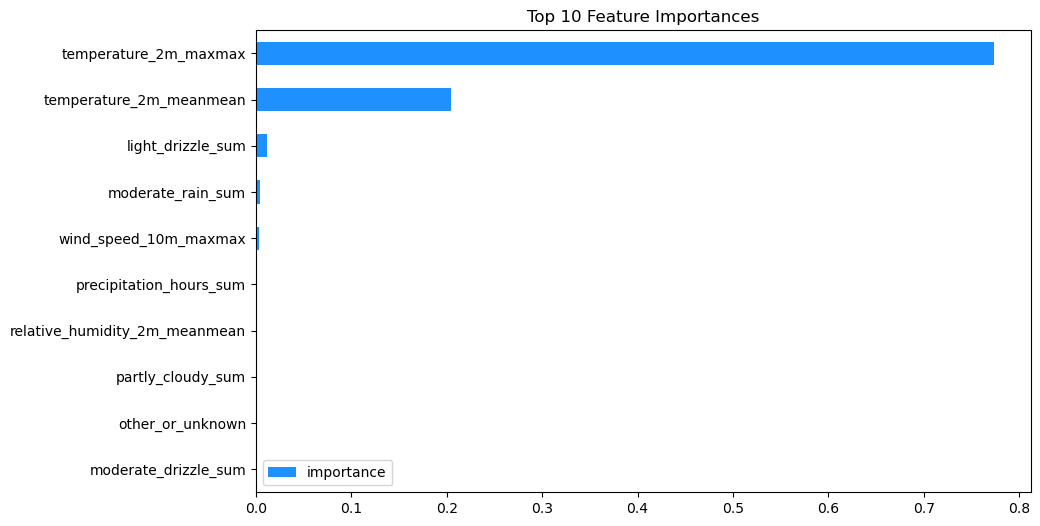

In [ ]:
fig = pd.DataFrame(data = reg.feature_importances_,
             index = reg.feature_names_in_,
             columns= ['importance'])

fig.sort_values('importance').tail(10).plot(kind = 'barh', figsize = (10, 6), color = 'dodgerblue', title = 'Top 10 Feature Importances')

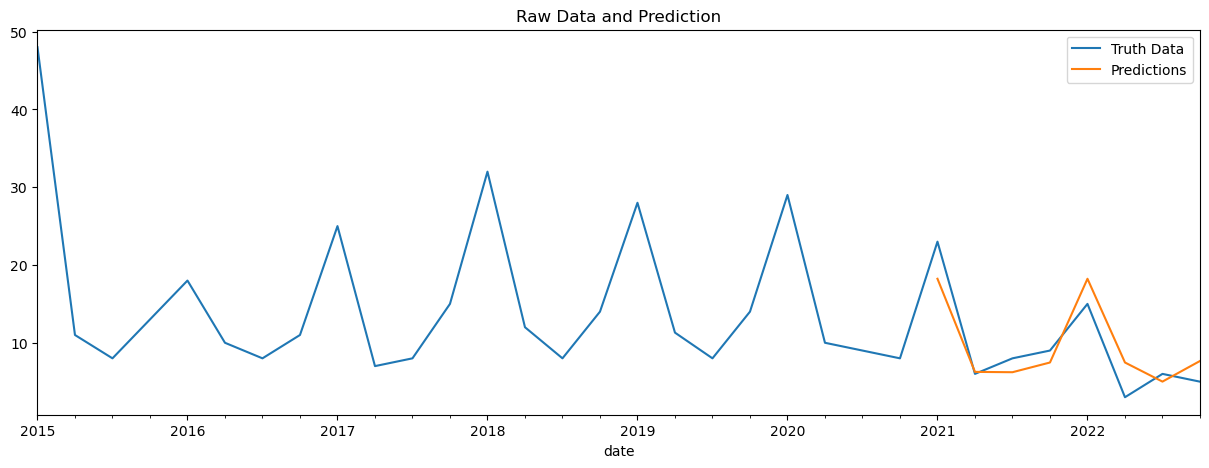

In [ ]:
test['prediction'] = reg.predict(X_test)
state_bees_forecast = state_bees.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = state_bees_forecast[['percent_lost']].plot(figsize=(15, 5))
state_bees_forecast['prediction'].plot(ax=ax, style='-')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

In [ ]:
score = np.sqrt(mean_squared_error(test['percent_lost'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 2.89


In [ ]:
def train_predict_plot(state, split_date):
    FEATURES = [
        'latitude', 'longitude', 'temperature_2m_meanmean',
        'temperature_2m_meansum', 'relative_humidity_2m_meanmean',
        'relative_humidity_2m_meansum', 'wind_speed_10m_maxmax',
        'temperature_2m_maxmax', 'relative_humidity_2m_maxmax',
        'temperature_2m_minmin', 'relative_humidity_2m_minmin',
        'precipitation_hours_sum', 'moderate_drizzle_sum', 'moderate_rain_sum',
        'light_rain_sum', 'heavy_rain_sum', 'overcast_sum', 'partly_cloudy_sum',
        'clear_sky_sum', 'light_drizzle_sum', 'mainly_clear_sum',
        'heavy_drizzle_sum', 'light_snow_sum', 'heavy_snow_sum',
        'moderate_snow_sum', 'year', 'D0_mean', 'D1_mean', 'D2_mean', 'D3_mean',
        'D4_mean', 'D0_max', 'D1_max', 'D2_max', 'D3_max', 'D4_max',
        'varroa_mites', 'other_pests_and_parasites', 'diseases', 'pesticides',
        'other_or_unknown'
    ]
    TARGET = 'percent_lost'
    
    # Filter and set index
    state_bees = bees[bees['state'] == state].copy()

    state_bees = create_quarterly_index(state_bees)
    state_bees.set_index('date', inplace=True)
    
    # Train/test split
    train = state_bees[state_bees.index < split_date]
    test = state_bees[state_bees.index >= split_date]

    # Plot train/test split
    fig, ax = plt.subplots(figsize=(15, 5))
    train.plot(ax=ax, y='percent_lost', label='Training Set', title='Data Train/Test Split')
    test.plot(ax=ax, y='percent_lost', label='Test Set')
    ax.set_ylabel('Percent Lost Bee Colonies')
    ax.set_title(f'Percent Lost Bee Colonies for {state}')
    ax.axvline(pd.to_datetime(split_date), color='black', ls='--')
    ax.legend(['Training Set', 'Test Set'])
    plt.show()

    # Prepare data
    X_train = train[FEATURES].copy()
    y_train = train[TARGET].copy()
    X_test = test[FEATURES].copy()
    y_test = test[TARGET].copy()

    # Train model
    reg = xgb.XGBRegressor(
        base_score=0.5,
        booster='gbtree',
        n_estimators=1000,
        early_stopping_rounds=50,
        objective='reg:linear',
        max_depth=5,
        learning_rate=0.01
    )
    reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose = False)

    # Feature importance
    importance_df = pd.DataFrame(data=reg.feature_importances_,
                                  index=reg.feature_names_in_,
                                  columns=['importance'])
    importance_df.sort_values('importance').tail(10).plot(kind='barh', figsize=(10, 6),
                                                          color='dodgerblue',
                                                          title='Top 10 Feature Importances')
    plt.show()

    # Prediction and plot
    test['prediction'] = reg.predict(X_test)
    state_bees_forecast = state_bees.merge(test[['prediction']], how='left', left_index=True, right_index=True)

    ax = state_bees_forecast[['percent_lost']].plot(figsize=(15, 5))
    state_bees_forecast['prediction'].plot(ax=ax, style='-')
    plt.legend(['Truth Data', 'Predictions'])
    ax.set_title('Raw Data and Prediction')
    plt.show()

    # Score
    score = np.sqrt(mean_squared_error(test[TARGET], test['prediction']))
    print(f'RMSE Score on Test set for {state}: {score:0.2f}')

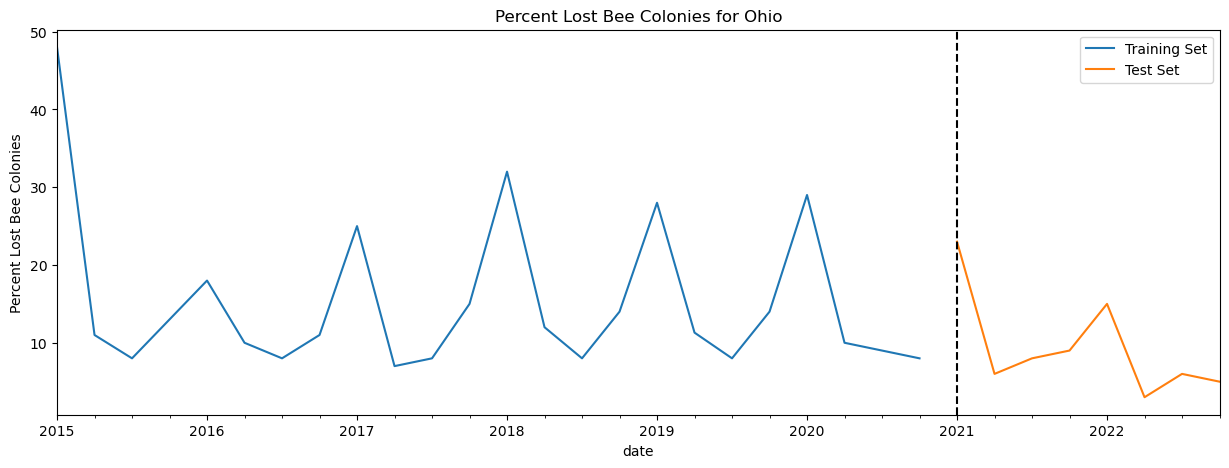

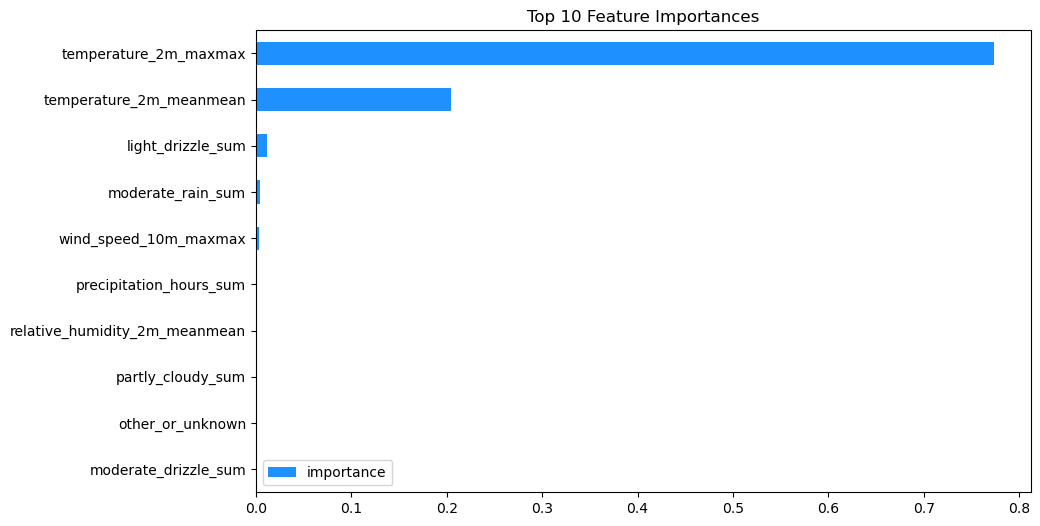

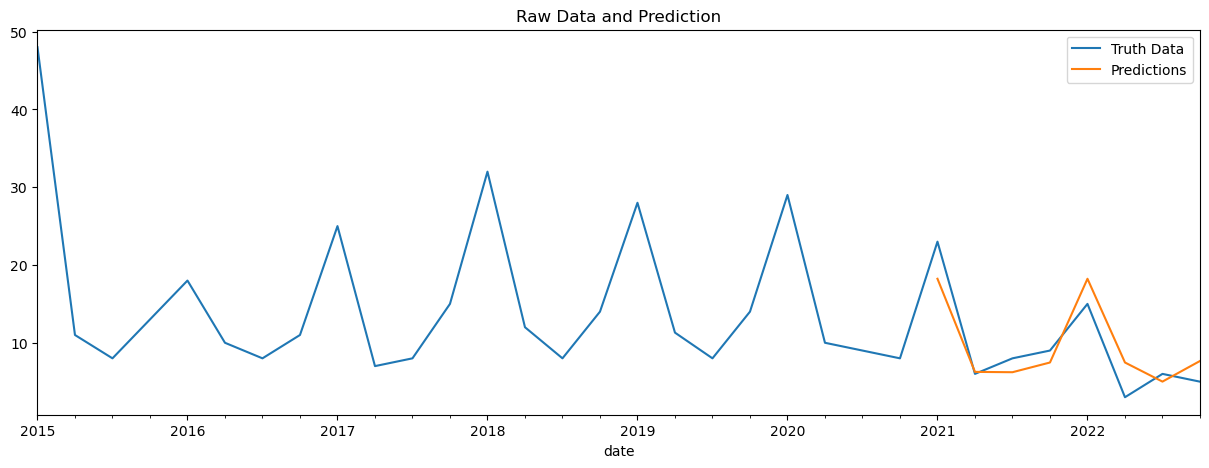

RMSE Score on Test set for Ohio: 2.89


In [ ]:
train_predict_plot('Ohio', '2021-01-01')

In [ ]:
def evaluate_xgb_by_history(state, split_date, min_years=1, max_years=5):
    """
    Evaluates and plots RMSE depending on how many years of historical data are used.

    Parameters:
        - state_bees: DataFrame with bee data (must include 'state', 'date', 'percent_lost' and FEATURES)
        - state: str, state to filter
        - split_date: str or datetime, fixed split point for testing
        - min_years: int, minimum history to try (e.g., 1)
        - max_years: int, maximum history to try (e.g., 5)
    """
    state_df = bees[bees['state'] == state].copy()
    state_df = create_quarterly_index(state_df)
    state_df.set_index('date', inplace=True)
    state_df.sort_index(inplace=True)

    FEATURES = [  # adapt as needed
        'latitude', 'longitude', 'temperature_2m_meanmean',
        'temperature_2m_meansum', 'relative_humidity_2m_meanmean',
        'relative_humidity_2m_meansum', 'wind_speed_10m_maxmax',
        'temperature_2m_maxmax', 'relative_humidity_2m_maxmax',
        'temperature_2m_minmin', 'relative_humidity_2m_minmin',
        'precipitation_hours_sum', 'moderate_drizzle_sum', 'moderate_rain_sum',
        'light_rain_sum', 'heavy_rain_sum', 'overcast_sum', 'partly_cloudy_sum',
        'clear_sky_sum', 'light_drizzle_sum', 'mainly_clear_sum',
        'heavy_drizzle_sum', 'light_snow_sum', 'heavy_snow_sum',
        'moderate_snow_sum', 'year', 'D0_mean', 'D1_mean', 'D2_mean', 'D3_mean',
        'D4_mean', 'D0_max', 'D1_max', 'D2_max', 'D3_max', 'D4_max',
        'varroa_mites', 'other_pests_and_parasites', 'diseases', 'pesticides',
        'other_or_unknown'
    ]
    TARGET = 'percent_lost'

    errors = []

    for years in range(min_years, max_years + 1):
        split_dt = pd.to_datetime(split_date)
        train_start = split_dt - pd.DateOffset(years=years)

        train = state_df.loc[(state_df.index >= train_start) & (state_df.index < split_dt)]
        test = state_df.loc[state_df.index >= split_dt]

        if len(train) < 5:
            print(f"Skipping {years} years: not enough training data.")
            continue

        X_train = train[FEATURES].copy()
        y_train = train[TARGET].copy()
        X_test = test[FEATURES].copy()
        y_test = test[TARGET].copy()

        reg = xgb.XGBRegressor(
            base_score=0.5, booster='gbtree',
            n_estimators=1000, early_stopping_rounds=10,
            objective='reg:squarederror',  # updated from 'reg:linear'
            max_depth=5, learning_rate=0.01
        )

        reg.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

        preds = reg.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, preds))
        errors.append((years, rmse))

    # Plot RMSE vs. training history
    history_lengths, rmse_scores = zip(*errors)
    plt.figure(figsize=(10, 5))
    plt.plot(history_lengths, rmse_scores, marker='o', color='teal')
    plt.title(f'RMSE vs. Training History Length (in Years) for {state}')
    plt.xlabel('Years of Historical Data Used')
    plt.ylabel('RMSE on Test Set')
    plt.grid(True)
    plt.show()

    return errors

Skipping 1 years: not enough training data.


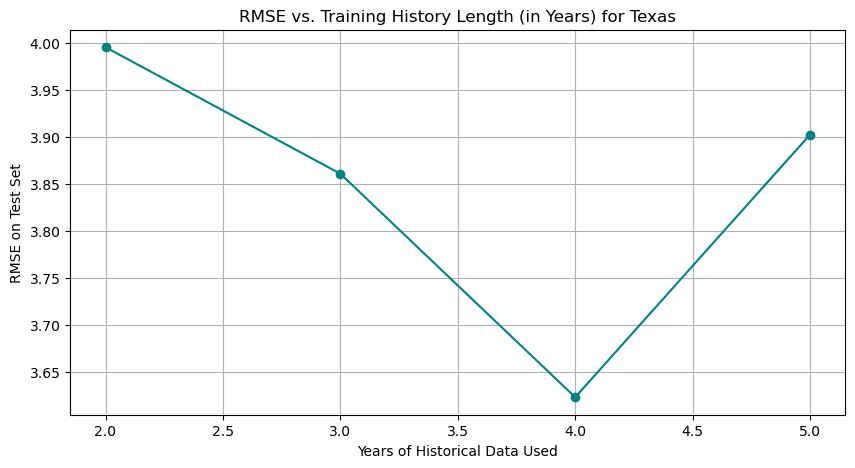

In [ ]:
xgb_rmse_results = evaluate_xgb_by_history(state='Texas', split_date='2021-01-01', min_years=1, max_years=5)

In [ ]:
def evaluate_xgb_rmse_by_history(states, split_date='2021-01-01', min_years=1, max_years=5):
    results = []

    for state in states:
        state_df = bees[bees['state'] == state].copy()
        state_df = create_quarterly_index(state_df)
        state_df.set_index('date', inplace=True)
        state_df.sort_index(inplace=True)


        for years in range(min_years, max_years + 1):
            split_dt = pd.to_datetime(split_date)
            train_start = split_dt - pd.DateOffset(years=years)

            train = state_df.loc[(state_df.index >= train_start) & (state_df.index < split_dt)]
            test = state_df.loc[state_df.index >= split_dt]

            if len(train) < 5 or len(test) == 0:
                continue  # skip if too little data

            FEATURES = [  # same as your existing FEATURES list
                'latitude', 'longitude', 'temperature_2m_meanmean',
                'temperature_2m_meansum', 'relative_humidity_2m_meanmean',
                'relative_humidity_2m_meansum', 'wind_speed_10m_maxmax',
                'temperature_2m_maxmax', 'relative_humidity_2m_maxmax',
                'temperature_2m_minmin', 'relative_humidity_2m_minmin',
                'precipitation_hours_sum', 'moderate_drizzle_sum', 'moderate_rain_sum',
                'light_rain_sum', 'heavy_rain_sum', 'overcast_sum', 'partly_cloudy_sum',
                'clear_sky_sum', 'light_drizzle_sum', 'mainly_clear_sum',
                'heavy_drizzle_sum', 'light_snow_sum', 'heavy_snow_sum',
                'moderate_snow_sum', 'year', 'D0_mean', 'D1_mean', 'D2_mean', 'D3_mean',
                'D4_mean', 'D0_max', 'D1_max', 'D2_max', 'D3_max', 'D4_max',
                'varroa_mites', 'other_pests_and_parasites', 'diseases', 'pesticides',
                'other_or_unknown'
            ]
            TARGET = 'percent_lost'

            X_train = train[FEATURES].copy()
            y_train = train[TARGET].copy()
            X_test = test[FEATURES].copy()
            y_test = test[TARGET].copy()

            reg = xgb.XGBRegressor(
                base_score=0.5, booster='gbtree',
                n_estimators=1000,
                early_stopping_rounds=50,
                objective='reg:squarederror',
                max_depth=5,
                learning_rate=0.01
            )

            reg.fit(X_train, y_train,
                    eval_set=[(X_train, y_train), (X_test, y_test)],
                    verbose=False)

            predictions = reg.predict(X_test)
            rmse = np.sqrt(mean_squared_error(y_test, predictions))

            results.append({
                'state': state,
                'train_years': years,
                'rmse': rmse
            })

    return pd.DataFrame(results)

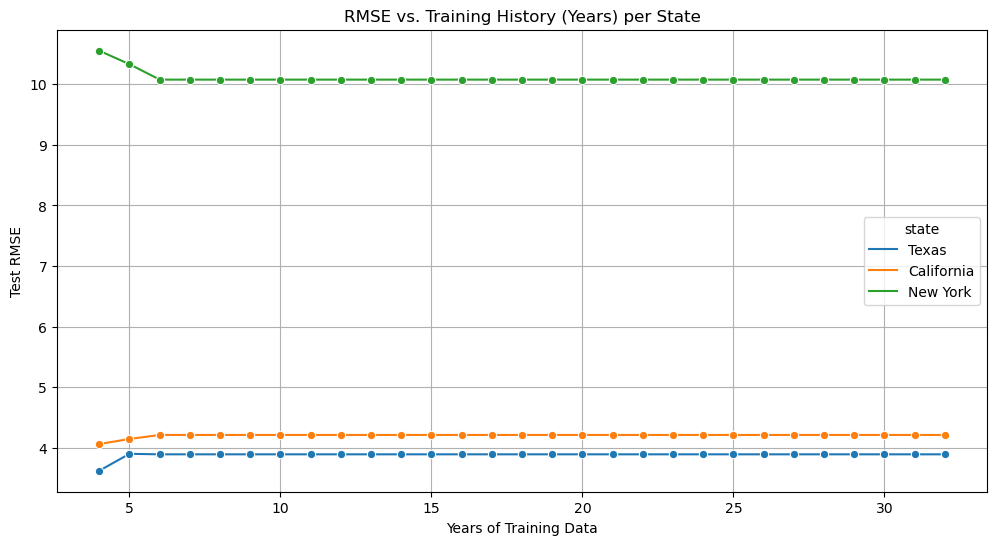

In [ ]:
states_of_interest = ['Texas', 'California', 'New York']

rmse_df = evaluate_xgb_rmse_by_history(states=states_of_interest, split_date='2021-01-01')

import seaborn as sns
plt.figure(figsize=(12,6))
sns.lineplot(data=rmse_df, x='train_years', y='rmse', hue='state', marker='o')
plt.title("RMSE vs. Training History (Years) per State")
plt.xlabel("Years of Training Data")
plt.ylabel("Test RMSE")
plt.grid(True)
plt.show()

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import pmdarima as pm

def evaluate_arima_rmse_by_history(states, split_date='2021-01-01', min_years=1, max_years=5):
    results = []

    for state in states:
        state_df = bees[bees['state'] == state].copy()
        state_df = create_quarterly_index(state_df)
        state_df.set_index('date', inplace=True)
        state_df.sort_index(inplace=True)

        for years in range(min_years, max_years + 1):
            split_dt = pd.to_datetime(split_date)
            train_start = split_dt - pd.DateOffset(years=years)

            train = state_df.loc[(state_df.index >= train_start) & (state_df.index < split_dt)]
            test = state_df.loc[state_df.index >= split_dt]

            y_train = train['percent_lost'].dropna()
            y_test = test['percent_lost'].dropna()

            # Skip if too few points
            if len(y_train) < 8 or len(y_test) < 1:
                continue

            try:
                # Fit ARIMA automatically (can be slow)
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    arima_model = pm.auto_arima(
                        y_train,
                        seasonal=False,
                        stepwise=True,
                        suppress_warnings=True,
                        error_action="ignore"
                    )

                # Forecast
                forecast = arima_model.predict(n_periods=len(y_test))
                rmse = np.sqrt(mean_squared_error(y_test, forecast))

                results.append({
                    'state': state,
                    'train_years': years,
                    'rmse': rmse
                })

            except Exception as e:
                print(f"ARIMA failed for {state} with {years} years: {e}")
                continue

    return pd.DataFrame(results)

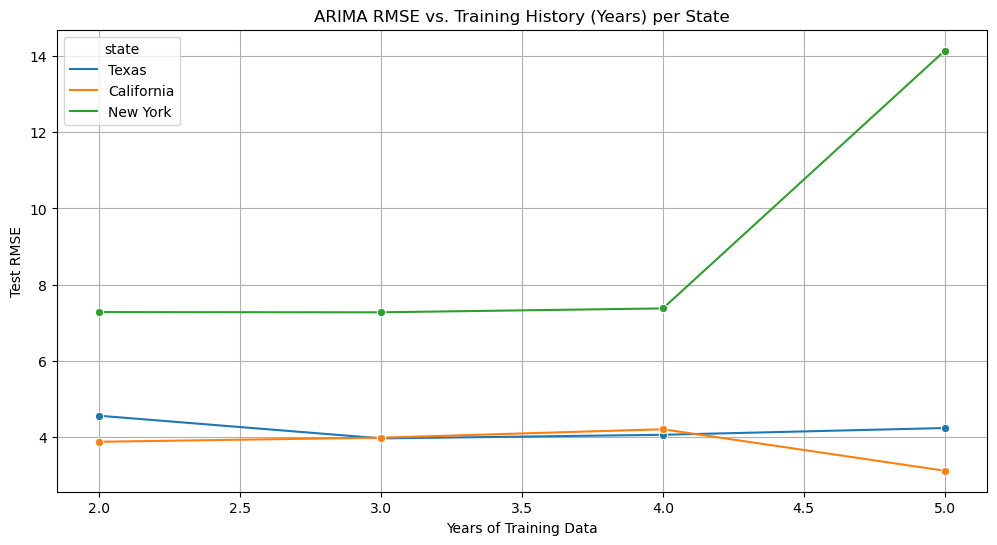

In [ ]:
rmse_df = evaluate_arima_rmse_by_history(
    states=['Texas', 'California', 'New York'],
    split_date='2022-01-01',
    min_years=1,
    max_years=5
)

import seaborn as sns
plt.figure(figsize=(12,6))
sns.lineplot(data=rmse_df, x='train_years', y='rmse', hue='state', marker='o')
plt.title("ARIMA RMSE vs. Training History (Years) per State")
plt.xlabel("Years of Training Data")
plt.ylabel("Test RMSE")
plt.grid(True)
plt.show()

In [ ]:
def compare_model_rmse_across_history(states, split_date='2021-01-01', min_years=1, max_years=5):
    # Call ARIMA results
    arima_results = evaluate_arima_rmse_by_history(states, split_date, min_years, max_years)
    arima_results['model'] = 'ARIMA'

    # Call XGBoost results
    xgb_results = evaluate_xgb_rmse_by_history(states, split_date, min_years, max_years)
    xgb_results['model'] = 'XGBoost'

    # Combine all
    combined = pd.concat([arima_results, xgb_results], ignore_index=True)

    return combined

In [ ]:
def plot_model_rmse_comparison(comparison_df):
    import seaborn as sns
    import matplotlib.pyplot as plt

    plt.figure(figsize=(14, 7))
    sns.lineplot(data=comparison_df, x='train_years', y='rmse', hue='model', style='model', marker='o')
    plt.title("Model RMSE vs. Training History")
    plt.xlabel("Years of Training Data")
    plt.ylabel("Test RMSE")
    plt.grid(True)
    plt.legend(title="Model")
    plt.show()

    # Optional: facet per state
    g = sns.FacetGrid(comparison_df, col="state", hue="model", height=4, col_wrap=3, sharey=False)
    g.map_dataframe(sns.lineplot, x="train_years", y="rmse", marker="o")
    g.add_legend()
    g.set_axis_labels("Years of Training Data", "Test RMSE")
    g.set_titles("State: {col_name}")
    plt.show()

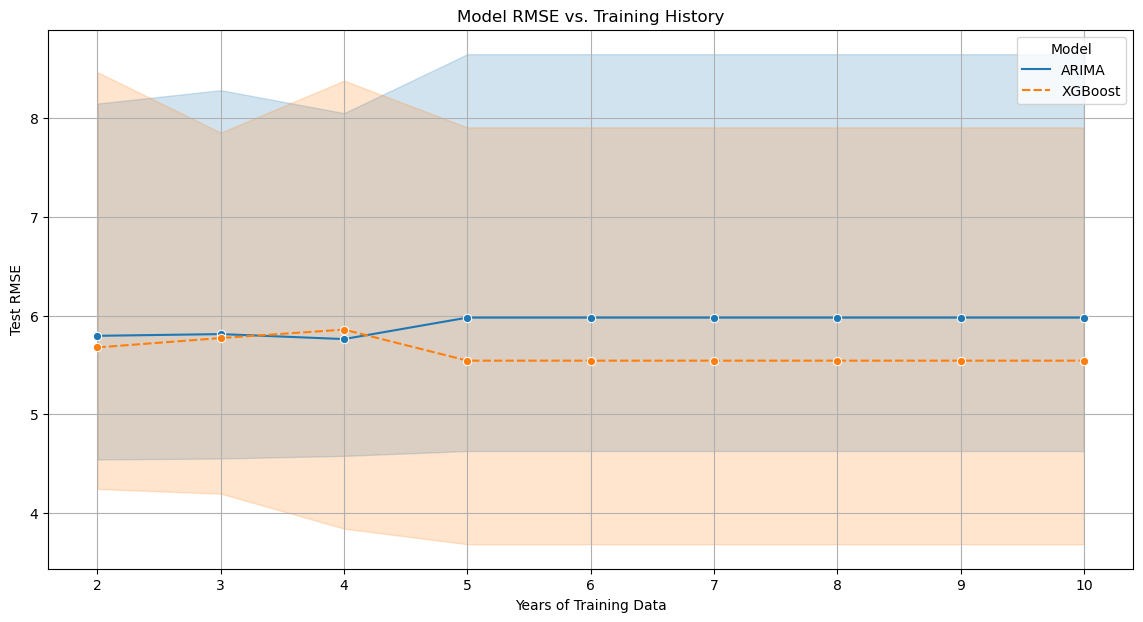

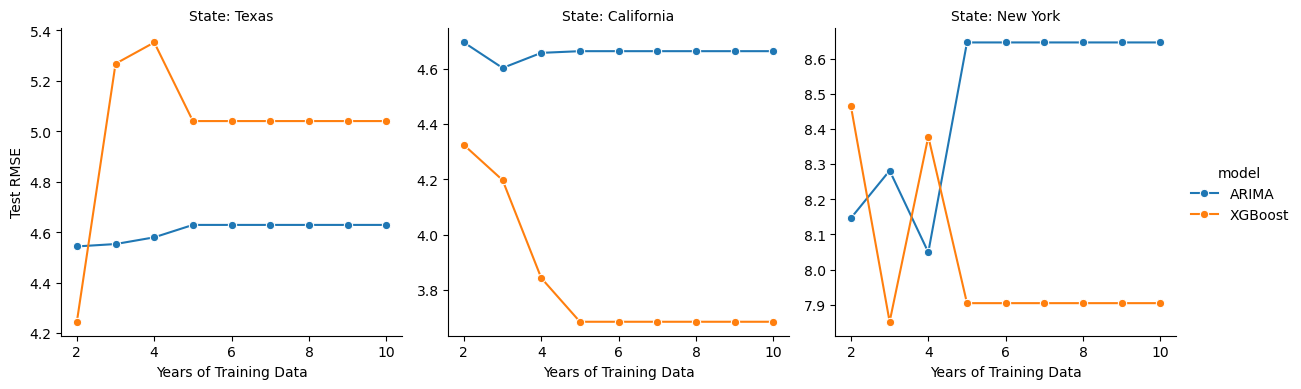

In [ ]:
comparison_df = compare_model_rmse_across_history(
    states=['Texas', 'California', 'New York'],
    split_date='2020-01-01',
    min_years=1,
    max_years=10
)

plot_model_rmse_comparison(comparison_df)

In [ ]:
def evaluate_xgb_rmse_by_quarters(states, split_date='2021-01-01', min_quarters=4, max_quarters=20):
    results = []

    for state in states:
        state_df = bees[bees['state'] == state].copy()
        state_df = create_quarterly_index(state_df)
        state_df.set_index('date', inplace=True)
        state_df.sort_index(inplace=True)

        for quarters in range(min_quarters, max_quarters + 1):
            split_dt = pd.to_datetime(split_date)
            train_start = split_dt - pd.DateOffset(months=3 * quarters)

            train = state_df.loc[(state_df.index >= train_start) & (state_df.index < split_dt)]
            test = state_df.loc[state_df.index >= split_dt]

            if len(train) < 5 or len(test) == 0:
                continue  # skip if too little data

            FEATURES = [  # Your existing feature list
                'latitude', 'longitude', 'temperature_2m_meanmean',
                'temperature_2m_meansum', 'relative_humidity_2m_meanmean',
                'relative_humidity_2m_meansum', 'wind_speed_10m_maxmax',
                'temperature_2m_maxmax', 'relative_humidity_2m_maxmax',
                'temperature_2m_minmin', 'relative_humidity_2m_minmin',
                'precipitation_hours_sum', 'moderate_drizzle_sum', 'moderate_rain_sum',
                'light_rain_sum', 'heavy_rain_sum', 'overcast_sum', 'partly_cloudy_sum',
                'clear_sky_sum', 'light_drizzle_sum', 'mainly_clear_sum',
                'heavy_drizzle_sum', 'light_snow_sum', 'heavy_snow_sum',
                'moderate_snow_sum', 'year', 'D0_mean', 'D1_mean', 'D2_mean', 'D3_mean',
                'D4_mean', 'D0_max', 'D1_max', 'D2_max', 'D3_max', 'D4_max',
                'varroa_mites', 'other_pests_and_parasites', 'diseases', 'pesticides',
                'other_or_unknown'
            ]
            TARGET = 'percent_lost'

            X_train = train[FEATURES].copy()
            y_train = train[TARGET].copy()
            X_test = test[FEATURES].copy()
            y_test = test[TARGET].copy()

            reg = xgb.XGBRegressor(
                base_score=0.5, booster='gbtree',
                n_estimators=1000,
                early_stopping_rounds=50,
                objective='reg:squarederror',
                max_depth=5,
                learning_rate=0.01
            )

            reg.fit(X_train, y_train,
                    eval_set=[(X_train, y_train), (X_test, y_test)],
                    verbose=False)

            predictions = reg.predict(X_test)
            rmse = np.sqrt(mean_squared_error(y_test, predictions))

            results.append({
                'state': state,
                'train_quarters': quarters,
                'rmse': rmse
            })

    return pd.DataFrame(results)


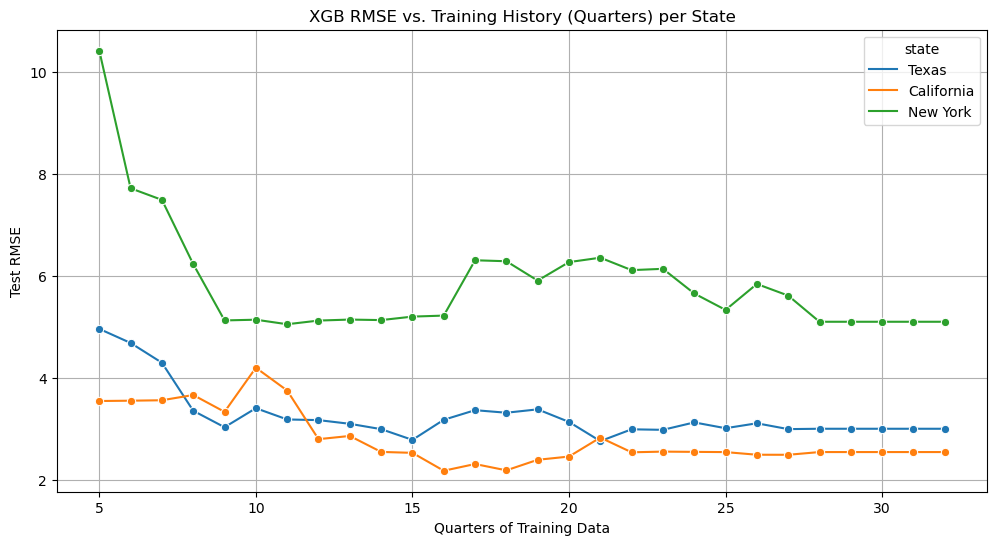

In [ ]:
rmse_df = evaluate_xgb_rmse_by_quarters(
    states=['Texas', 'California', 'New York'],
    split_date='2022-01-01',
    min_quarters=1,
    max_quarters=32
)

import seaborn as sns
plt.figure(figsize=(12,6))
sns.lineplot(data=rmse_df, x='train_quarters', y='rmse', hue='state', marker='o')
plt.title("XGB RMSE vs. Training History (Quarters) per State")
plt.xlabel("Quarters of Training Data")
plt.ylabel("Test RMSE")
plt.grid(True)
plt.show()

In [ ]:
def evaluate_xgb_rmse_by_quarters(states, split_date='2020-01-01', min_quarters=4, max_quarters=24):
    results = []

    for state in states:
        state_df = bees[bees['state'] == state].copy()
        state_df = create_quarterly_index(state_df)
        state_df.set_index('date', inplace=True)
        state_df.sort_index(inplace=True)

        for quarters in range(min_quarters, max_quarters + 1):
            split_dt = pd.to_datetime(split_date)
            train_start = split_dt - pd.DateOffset(months=3 * quarters)

            train = state_df.loc[(state_df.index >= train_start) & (state_df.index < split_dt)]
            test = state_df.loc[state_df.index >= split_dt]

            if len(train) < 5 or len(test) == 0:
                continue  # skip if too little data

            FEATURES = [
                'latitude', 'longitude', 'temperature_2m_meanmean',
                'temperature_2m_meansum', 'relative_humidity_2m_meanmean',
                'relative_humidity_2m_meansum', 'wind_speed_10m_maxmax',
                'temperature_2m_maxmax', 'relative_humidity_2m_maxmax',
                'temperature_2m_minmin', 'relative_humidity_2m_minmin',
                'precipitation_hours_sum', 'moderate_drizzle_sum', 'moderate_rain_sum',
                'light_rain_sum', 'heavy_rain_sum', 'overcast_sum', 'partly_cloudy_sum',
                'clear_sky_sum', 'light_drizzle_sum', 'mainly_clear_sum',
                'heavy_drizzle_sum', 'light_snow_sum', 'heavy_snow_sum',
                'moderate_snow_sum', 'year', 'D0_mean', 'D1_mean', 'D2_mean', 'D3_mean',
                'D4_mean', 'D0_max', 'D1_max', 'D2_max', 'D3_max', 'D4_max',
                'varroa_mites', 'other_pests_and_parasites', 'diseases', 'pesticides',
                'other_or_unknown'
            ]
            TARGET = 'percent_lost'

            X_train = train[FEATURES].copy()
            y_train = train[TARGET].copy()
            X_test = test[FEATURES].copy()
            y_test = test[TARGET].copy()

            reg = xgb.XGBRegressor(
                base_score=0.5, booster='gbtree',
                n_estimators=1000,
                early_stopping_rounds=50,
                objective='reg:squarederror',
                max_depth=5,
                learning_rate=0.01
            )

            reg.fit(X_train, y_train,
                    eval_set=[(X_train, y_train), (X_test, y_test)],
                    verbose=False)

            predictions = reg.predict(X_test)
            rmse = np.sqrt(mean_squared_error(y_test, predictions))
            mean_percent_lost = y_train.mean()

            results.append({
                'state': state,
                'train_quarters': quarters,
                'rmse': rmse,
                'mean_percent_lost': mean_percent_lost
            })

    return pd.DataFrame(results)

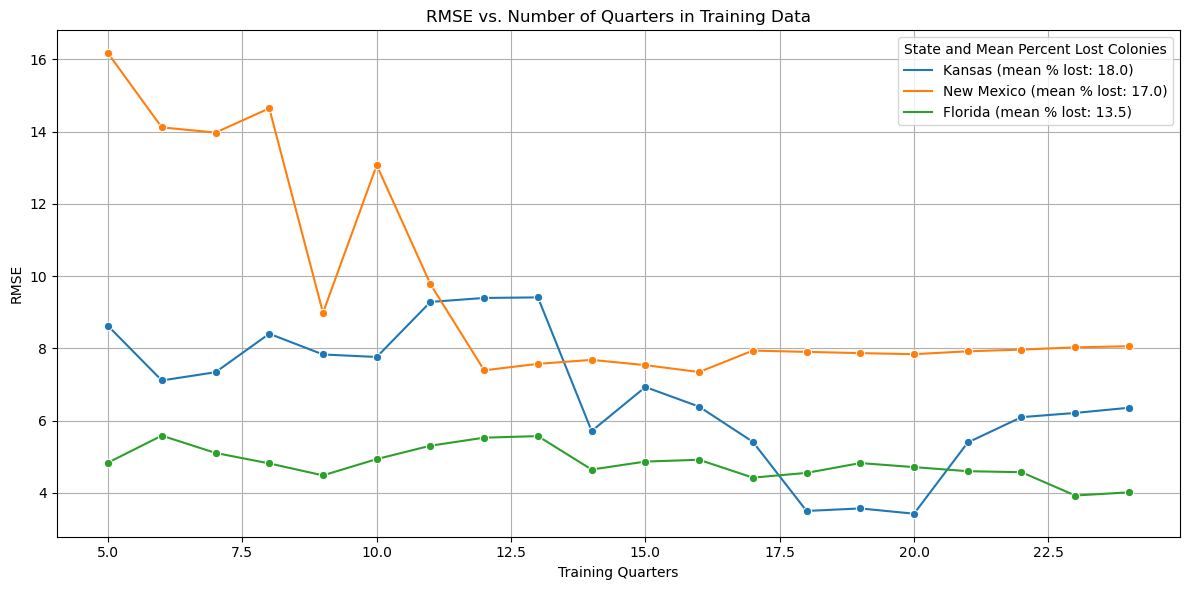

In [ ]:
results_df = evaluate_xgb_rmse_by_quarters(states=['Kansas','New Mexico', 'Florida'], split_date='2021-01-01')

# Create a mapping from state to its mean percent lost
mean_lost_map = results_df.groupby('state')['mean_percent_lost'].mean().round(1)

# Create new labels that include the mean for each state
results_df['state_with_mean'] = results_df['state'].apply(
    lambda s: f"{s} (mean % lost: {mean_lost_map[s]})"
)

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=results_df,
    x='train_quarters',
    y='rmse',
    hue='state_with_mean',
    marker='o'
)

plt.title('XGB RMSE vs. Number of Quarters in Training Data')
plt.xlabel('Training Quarters')
plt.ylabel('RMSE')
plt.legend(title='State and Mean Percent Lost Colonies')
plt.tight_layout()
plt.grid(True)
plt.show()

In [ ]:
def evaluate_xgb_with_lags_by_quarter(states, split_date='2021-01-01', min_quarters=4, max_quarters=20, max_lag=4):
    results = []

    for state in states:
        state_df = bees[bees['state'] == state].copy()
        state_df = create_quarterly_index(state_df)
        state_df.set_index('date', inplace=True)
        state_df.sort_index(inplace=True)

        # Create lag features
        for lag in range(1, max_lag + 1):
            state_df[f'lag_{lag}'] = state_df['percent_lost'].shift(lag)

        # Drop rows with NaNs from lagging
        state_df.dropna(inplace=True)

        for quarters in range(min_quarters, max_quarters + 1):
            split_dt = pd.to_datetime(split_date)
            # Calculate train start by subtracting quarters
            train_start = split_dt - pd.DateOffset(months=3*quarters)

            # Split the data into train and test sets
            train = state_df.loc[(state_df.index >= train_start) & (state_df.index < split_dt)]
            test = state_df.loc[state_df.index >= split_dt]

            if len(train) < 5 or len(test) == 0:
                continue

            # Define features (including lagged features)
            FEATURES = [
                'latitude', 'longitude', 'temperature_2m_meanmean',
                'temperature_2m_meansum', 'relative_humidity_2m_meanmean',
                'relative_humidity_2m_meansum', 'wind_speed_10m_maxmax',
                'temperature_2m_maxmax', 'relative_humidity_2m_maxmax',
                'temperature_2m_minmin', 'relative_humidity_2m_minmin',
                'precipitation_hours_sum', 'moderate_drizzle_sum', 'moderate_rain_sum',
                'light_rain_sum', 'heavy_rain_sum', 'overcast_sum', 'partly_cloudy_sum',
                'clear_sky_sum', 'light_drizzle_sum', 'mainly_clear_sum',
                'heavy_drizzle_sum', 'light_snow_sum', 'heavy_snow_sum',
                'moderate_snow_sum', 'year', 'D0_mean', 'D1_mean', 'D2_mean', 'D3_mean',
                'D4_mean', 'D0_max', 'D1_max', 'D2_max', 'D3_max', 'D4_max',
                'varroa_mites', 'other_pests_and_parasites', 'diseases', 'pesticides',
                'other_or_unknown'
            ] + [f'lag_{i}' for i in range(1, max_lag + 1)]

            TARGET = 'percent_lost'

            # Prepare training and testing datasets
            X_train = train[FEATURES].copy()
            y_train = train[TARGET].copy()
            X_test = test[FEATURES].copy()
            y_test = test[TARGET].copy()

            # Initialize and train XGBoost model
            reg = xgb.XGBRegressor(
                base_score=0.5, booster='gbtree',
                n_estimators=1000,
                early_stopping_rounds=50,
                objective='reg:squarederror',
                max_depth=5,
                learning_rate=0.01
            )

            reg.fit(X_train, y_train,
                    eval_set=[(X_train, y_train), (X_test, y_test)],
                    verbose=False)

            # Predict and evaluate the model
            predictions = reg.predict(X_test)
            rmse = np.sqrt(mean_squared_error(y_test, predictions))
            mean_percent_lost = y_train.mean()

            # Store the results for each state and quarter configuration
            results.append({
                'state': state,
                'train_quarters': quarters,
                'rmse': rmse,
                'mean_percent_lost': mean_percent_lost
            })

    return pd.DataFrame(results)

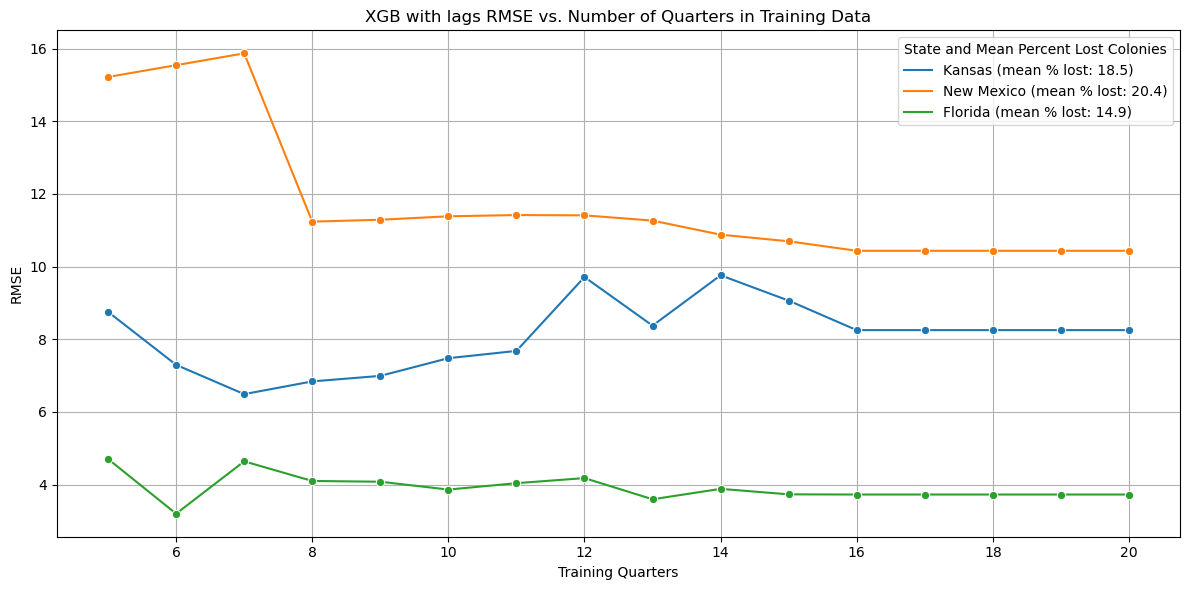

In [ ]:
results_df = evaluate_xgb_with_lags_by_quarter(states=['Kansas','New Mexico', 'Florida'], split_date='2020-01-01', min_quarters=4, max_quarters=20, max_lag=4)

# Create a mapping from state to its mean percent lost
mean_lost_map = results_df.groupby('state')['mean_percent_lost'].mean().round(1)

# Create new labels that include the mean for each state
results_df['state_with_mean'] = results_df['state'].apply(
    lambda s: f"{s} (mean % lost: {mean_lost_map[s]})"
)

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=results_df,
    x='train_quarters',
    y='rmse',
    hue='state_with_mean',
    marker='o'
)

plt.title('XGB with lags RMSE vs. Number of Quarters in Training Data')
plt.xlabel('Training Quarters')
plt.ylabel('RMSE')
plt.legend(title='State and Mean Percent Lost Colonies')
plt.tight_layout()
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

def evaluate_arima_rmse_by_quarters(bees, states, split_date='2020-01-01', min_quarters=4, max_quarters=24):
    results = []

    for state in states:
        state_df = bees[bees['state'] == state].copy()
        state_df = create_quarterly_index(state_df)  # Ensure quarterly indexing
        state_df.set_index('date', inplace=True)
        state_df.sort_index(inplace=True)

        for quarters in range(min_quarters, max_quarters + 1):
            split_dt = pd.to_datetime(split_date)
            # Calculate the start of the training period by subtracting quarters
            train_start = split_dt - pd.DateOffset(months=3 * quarters)

            train = state_df.loc[(state_df.index >= train_start) & (state_df.index < split_dt)]
            test = state_df.loc[state_df.index >= split_dt]

            if len(train) < 5 or len(test) == 0:
                continue  # skip if too little data

            TARGET = 'percent_lost'

            # Train ARIMA model (only using the target variable)
            y_train = train[TARGET].copy()
            y_test = test[TARGET].copy()

            try:
                # Fit ARIMA model (adjusting the order (p, d, q) if necessary)
                model = auto_arima(y_train, seasonal=False, stepwise=True, trace=False)
                

                # Make predictions
                predictions = model.predict(n_periods=len(test))
                rmse = np.sqrt(mean_squared_error(y_test, predictions))
                mae = mean_absolute_error(y_test, predictions)

                # Calculate mean of the training target for reference
                mean_percent_lost = y_train.mean()

                # Store results
                results.append({
                    'state': state,
                    'train_quarters': quarters,
                    'rmse': rmse,
                    'mae': mae,
                    'mean_percent_lost': mean_percent_lost
                })
            except Exception as e:
                print(f"Error for state {state} with {quarters} quarters of training: {e}")
                continue

    return pd.DataFrame(results)


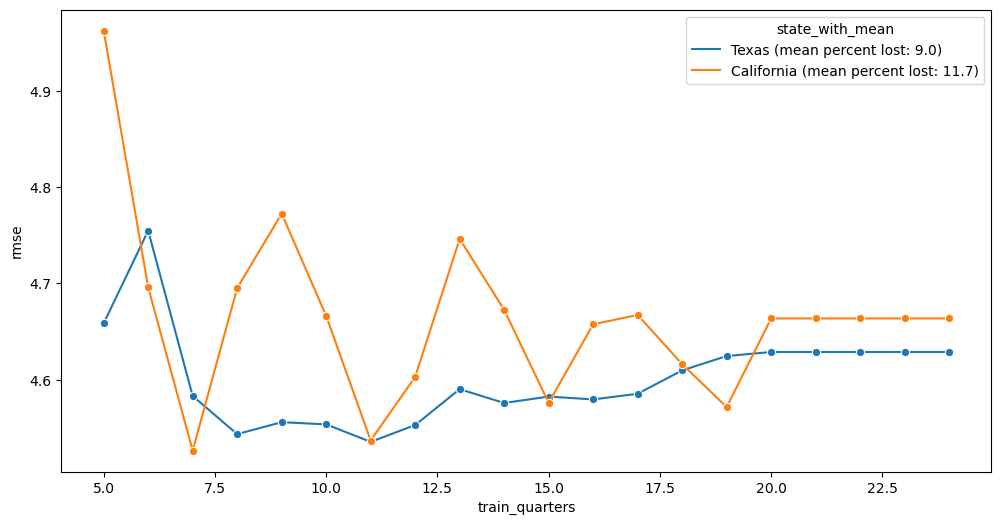

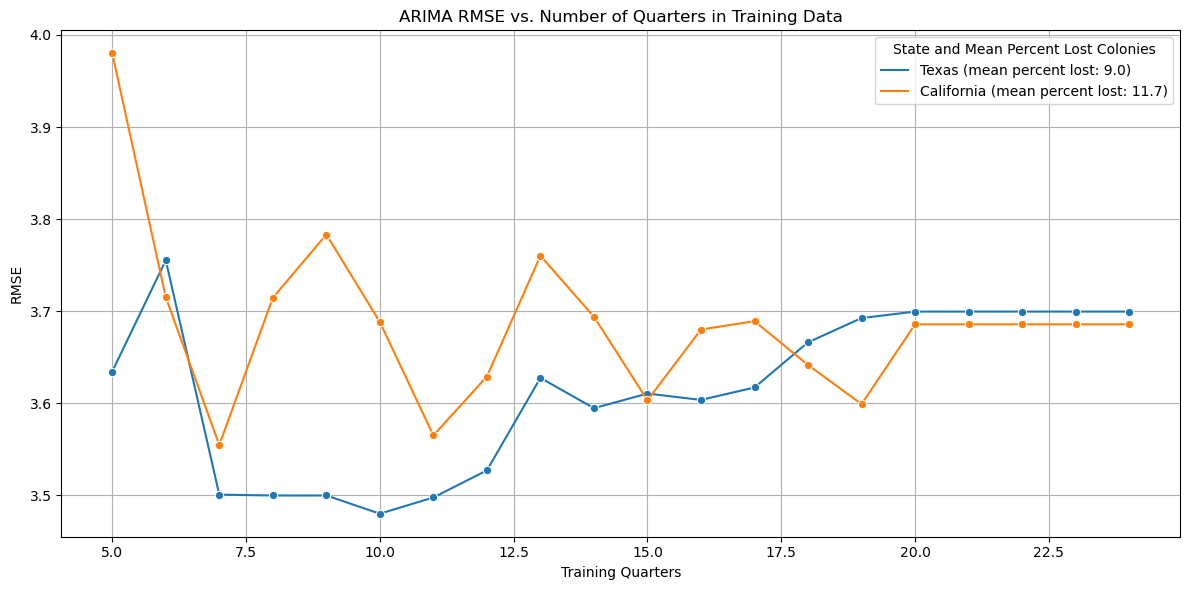

In [ ]:
results_df = evaluate_arima_rmse_by_quarters(bees, ['Texas', 'California'], split_date='2020-01-01', min_quarters=1, max_quarters=24)

# Create a mapping from state to its mean percent lost
mean_lost_map = results_df.groupby('state')['mean_percent_lost'].mean().round(1)

# Create new labels that include the mean for each state
results_df['state_with_mean'] = results_df['state'].apply(
    lambda s: f"{s} (mean percent lost: {mean_lost_map[s]})"
)

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=results_df,
    x='train_quarters',
    y='rmse',
    hue='state_with_mean',
    marker='o'
)

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=results_df,
    x='train_quarters',
    y='mae',
    hue='state_with_mean',
    marker='o'
)

plt.title('ARIMA RMSE vs. Number of Quarters in Training Data')
plt.xlabel('Training Quarters')
plt.ylabel('RMSE')
plt.legend(title='State and Mean Percent Lost Colonies')
plt.tight_layout()
plt.grid(True)
plt.show()

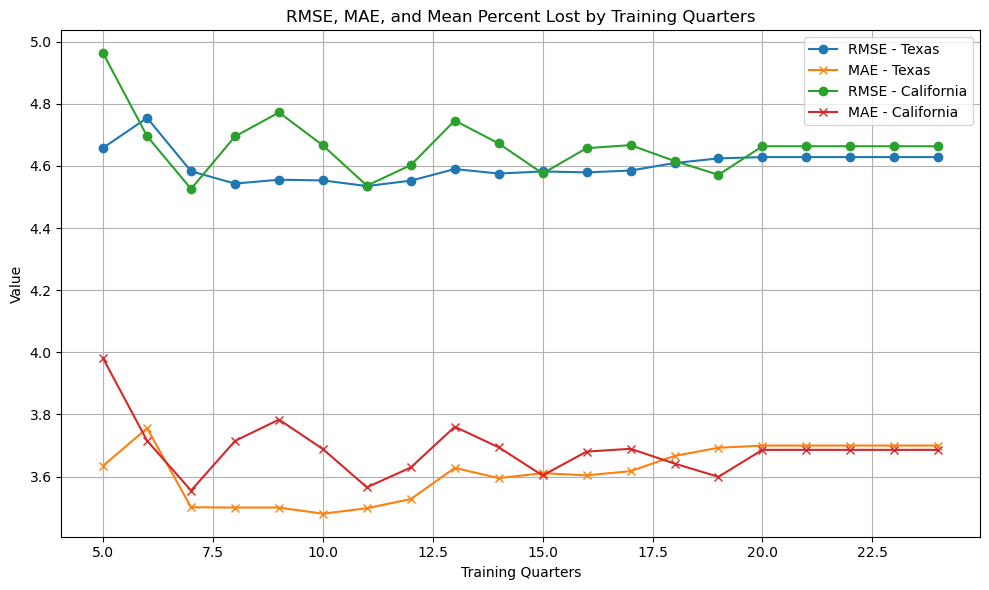

In [ ]:
def plot_metrics(results):
    # Plot RMSE, MAE, and mean_percent_lost
    plt.figure(figsize=(10, 6))

    # Loop through the states and plot the metrics
    for state in results['state'].unique():
        state_data = results[results['state'] == state]
        
        plt.plot(state_data['train_quarters'], state_data['rmse'], label=f'RMSE - {state}', marker='o')
        plt.plot(state_data['train_quarters'], state_data['mae'], label=f'MAE - {state}', marker='x')

    # Customize plot
    plt.title('RMSE, MAE, and Mean Percent Lost by Training Quarters')
    plt.xlabel('Training Quarters')
    plt.ylabel('Value')
    plt.legend(loc='upper right')
    plt.grid(True)

    # Show the plot
    plt.tight_layout()
    plt.show()

# Example usage:
plot_metrics(results_df)

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error

def create_lagged_features(df, lags=3):
    """
    Creates lagged features based on the target variable.
    df: DataFrame containing historical data.
    lags: Number of lags to create (e.g., 1, 2, 3 quarters).
    """
    for lag in range(1, lags + 1):
        df[f'percent_lost_lag{lag}'] = df['percent_lost'].shift(lag)
    
    return df

def evaluate_xgb_rmse_by_lags(states, split_date='2020-01-01', min_quarters=4, max_quarters=24, lags=3):
    results = []

    for state in states:
        state_df = bees[bees['state'] == state].copy()
        state_df = create_quarterly_index(state_df)
        state_df.set_index('date', inplace=True)
        state_df.sort_index(inplace=True)

        # Convert split_date to datetime
        split_dt = pd.to_datetime(split_date)

        # Calculate the number of available quarters before the split_date
        available_quarters = ((split_dt - state_df.index[0]).days // 90)  # Approx. 3 months per quarter

        # Adjust max_quarters based on the available quarters
        adjusted_max_quarters = min(max_quarters, available_quarters)

        # Create lagged features
        state_df = create_lagged_features(state_df, lags=lags)

        for quarters in range(min_quarters, adjusted_max_quarters + 1):
            train_start = split_dt - pd.DateOffset(months=3 * quarters)

            # Make sure the training data is not larger than the available data
            if train_start < state_df.index[0]:
                train_start = state_df.index[0]  # Adjust start date to the first available date

            train = state_df.loc[(state_df.index >= train_start) & (state_df.index < split_dt)]
            test = state_df.loc[state_df.index >= split_dt]

            if len(train) < 5 or len(test) == 0:
                continue  # skip if too little data

            FEATURES = [
                'latitude', 'longitude', 'temperature_2m_meanmean',
                'temperature_2m_meansum', 'relative_humidity_2m_meanmean',
                'relative_humidity_2m_meansum', 'wind_speed_10m_maxmax',
                'temperature_2m_maxmax', 'relative_humidity_2m_maxmax',
                'temperature_2m_minmin', 'relative_humidity_2m_minmin',
                'precipitation_hours_sum', 'moderate_drizzle_sum', 'moderate_rain_sum',
                'light_rain_sum', 'heavy_rain_sum', 'overcast_sum', 'partly_cloudy_sum',
                'clear_sky_sum', 'light_drizzle_sum', 'mainly_clear_sum',
                'heavy_drizzle_sum', 'light_snow_sum', 'heavy_snow_sum',
                'moderate_snow_sum', 'year', 'D0_mean', 'D1_mean', 'D2_mean', 'D3_mean',
                'D4_mean', 'D0_max', 'D1_max', 'D2_max', 'D3_max', 'D4_max',
                'varroa_mites', 'other_pests_and_parasites', 'diseases', 'pesticides',
                'other_or_unknown'
            ]

            # Add lag features to the list of features
            for lag in range(1, lags + 1):
                FEATURES.append(f'percent_lost_lag{lag}')

            TARGET = 'percent_lost'

            # Drop rows with NaN values resulting from lagging
            train = train.dropna(subset=FEATURES)
            test = test.dropna(subset=FEATURES)

            X_train = train[FEATURES].copy()
            y_train = train[TARGET].copy()
            X_test = test[FEATURES].copy()
            y_test = test[TARGET].copy()

            reg = xgb.XGBRegressor(
                base_score=0.5, booster='gbtree',
                n_estimators=1000,
                early_stopping_rounds=50,
                objective='reg:squarederror',
                max_depth=5,
                learning_rate=0.01
            )

            reg.fit(X_train, y_train,
                    eval_set=[(X_train, y_train), (X_test, y_test)],
                    verbose=False)

            predictions = reg.predict(X_test)
            rmse = np.sqrt(mean_squared_error(y_test, predictions))
            mae = np.mean(np.abs(y_test - predictions))
            mean_percent_lost = y_train.mean()

            results.append({
                'state': state,
                'train_quarters': quarters,
                'rmse': rmse,
                'mae': mae,
                'mean_percent_lost': mean_percent_lost
            })

    return pd.DataFrame(results)

# Example usage
states = ['Texas', 'California']  # List of states you want to analyze
results_df = evaluate_xgb_rmse_by_lags(states, split_date='2020-01-01', min_quarters=4, max_quarters=24, lags=3)


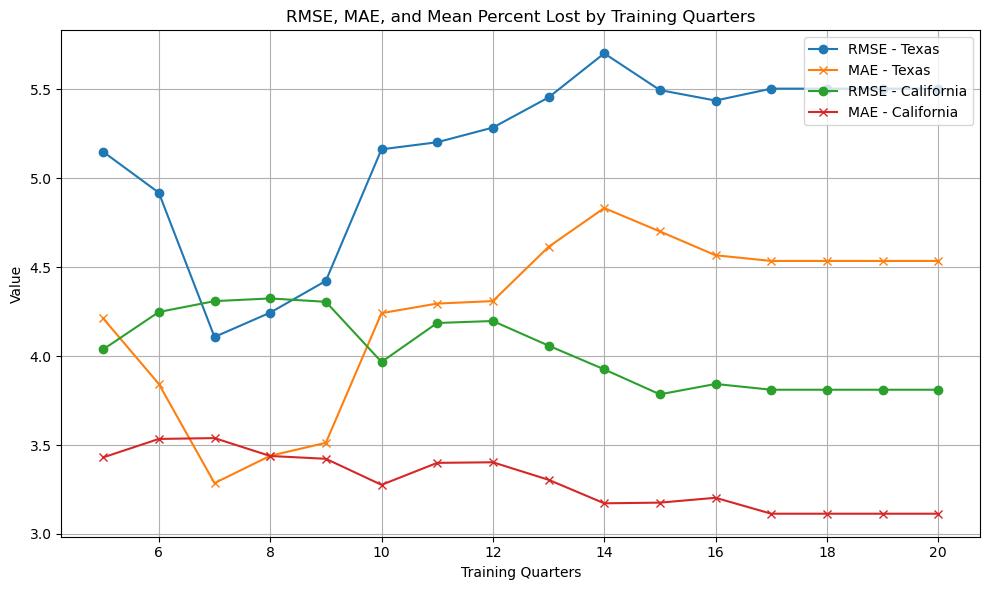

In [ ]:
plot_metrics(results_df)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

def create_lagged_features(df, lags=3):
    """
    Creates lagged features based on the target variable.
    df: DataFrame containing historical data.
    lags: Number of lags to create (e.g., 1, 2, 3 quarters).
    """
    for lag in range(1, lags + 1):
        df[f'percent_lost_lag{lag}'] = df['percent_lost'].shift(lag)
    
    return df

def evaluate_rf_rmse_by_lags(states, split_date='2020-01-01', min_quarters=4, max_quarters=24, lags=3):
    results = []

    for state in states:
        state_df = bees[bees['state'] == state].copy()
        state_df = create_quarterly_index(state_df)
        state_df.set_index('date', inplace=True)
        state_df.sort_index(inplace=True)

        # Convert split_date to datetime
        split_dt = pd.to_datetime(split_date)

        # Calculate the number of available quarters before the split_date
        available_quarters = ((split_dt - state_df.index[0]).days // 90)  # Approx. 3 months per quarter

        # Adjust max_quarters based on the available quarters
        adjusted_max_quarters = min(max_quarters, available_quarters)

        # Create lagged features
        state_df = create_lagged_features(state_df, lags=lags)

        for quarters in range(min_quarters, adjusted_max_quarters + 1):
            train_start = split_dt - pd.DateOffset(months=3 * quarters)

            # Make sure the training data is not larger than the available data
            if train_start < state_df.index[0]:
                train_start = state_df.index[0]  # Adjust start date to the first available date

            train = state_df.loc[(state_df.index >= train_start) & (state_df.index < split_dt)]
            test = state_df.loc[state_df.index >= split_dt]

            if len(train) < 5 or len(test) == 0:
                continue  # skip if too little data

            FEATURES = [
                'latitude', 'longitude', 'temperature_2m_meanmean',
                'temperature_2m_meansum', 'relative_humidity_2m_meanmean',
                'relative_humidity_2m_meansum', 'wind_speed_10m_maxmax',
                'temperature_2m_maxmax', 'relative_humidity_2m_maxmax',
                'temperature_2m_minmin', 'relative_humidity_2m_minmin',
                'precipitation_hours_sum', 'moderate_drizzle_sum', 'moderate_rain_sum',
                'light_rain_sum', 'heavy_rain_sum', 'overcast_sum', 'partly_cloudy_sum',
                'clear_sky_sum', 'light_drizzle_sum', 'mainly_clear_sum',
                'heavy_drizzle_sum', 'light_snow_sum', 'heavy_snow_sum',
                'moderate_snow_sum', 'year', 'D0_mean', 'D1_mean', 'D2_mean', 'D3_mean',
                'D4_mean', 'D0_max', 'D1_max', 'D2_max', 'D3_max', 'D4_max',
                'varroa_mites', 'other_pests_and_parasites', 'diseases', 'pesticides',
                'other_or_unknown'
            ]

            # Add lag features to the list of features
            for lag in range(1, lags + 1):
                FEATURES.append(f'percent_lost_lag{lag}')

            TARGET = 'percent_lost'

            # Drop rows with NaN values resulting from lagging
            train = train.dropna(subset=FEATURES)
            test = test.dropna(subset=FEATURES)

            X_train = train[FEATURES].copy()
            y_train = train[TARGET].copy()
            X_test = test[FEATURES].copy()
            y_test = test[TARGET].copy()

            # Initialize RandomForestRegressor
            rf = RandomForestRegressor(
                n_estimators=1000,
                max_depth=5,
                random_state=42
            )

            rf.fit(X_train, y_train)

            # Predictions
            predictions = rf.predict(X_test)
            rmse = np.sqrt(mean_squared_error(y_test, predictions))
            mae = mean_absolute_error(y_test, predictions)
            mean_percent_lost = y_train.mean()

            results.append({
                'state': state,
                'train_quarters': quarters,
                'rmse': rmse,
                'mae': mae,
                'mean_percent_lost': mean_percent_lost
            })

    return pd.DataFrame(results)

# Example usage
states = ['Texas', 'California']  # List of states you want to analyze
results_df = evaluate_rf_rmse_by_lags(states, split_date='2020-01-01', min_quarters=4, max_quarters=24, lags=3)


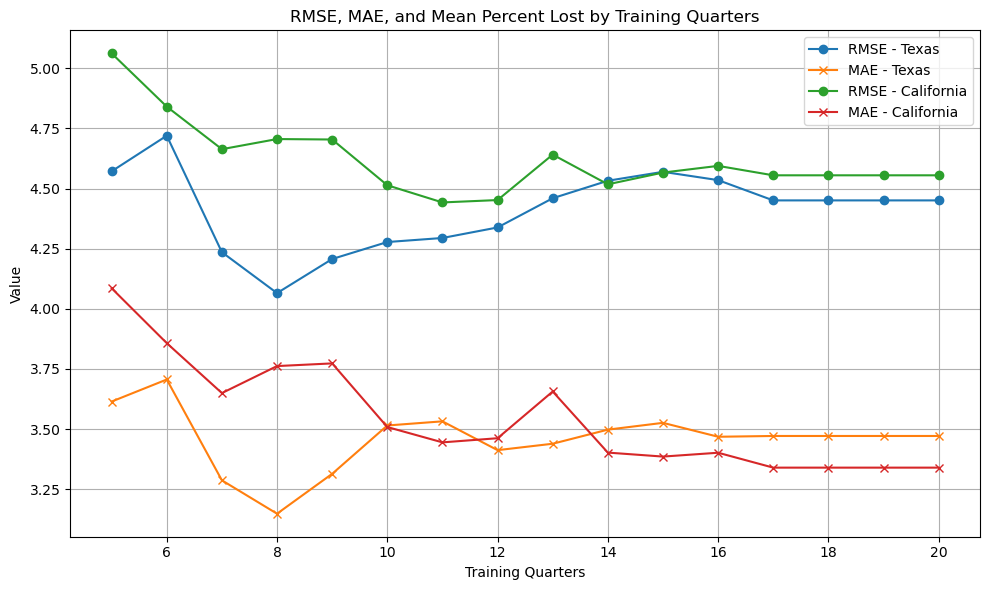

In [ ]:
plot_metrics(results_df)